In [1]:
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.14"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.14) to /tmp/pip-install-eze9c7yt/tsfm-public_93cd9b5772c1487ba1391a171a2e16e6
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-eze9c7yt/tsfm-public_93cd9b5772c1487ba1391a171a2e16e6
  Running command git checkout -q fea9e7e578065d38491f777422a43cea71564994
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit fea9e7e578065d38491f777422a43cea71564994
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.8 MB/s eta 0:00:00
  Created wheel for tsfm

In [6]:
import math
import os
import tempfile
import logging
from pathlib import Path
from typing import Optional
import pandas as pd
import yaml

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TrackingCallback, count_parameters, load_dataset
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor, ScalerType, TimeSeriesTask, prepare_data_splits, get_datasets

In [7]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

In [21]:
SEED = 42
set_seed(SEED)

TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
OUT_DIR = "ttm_finetuned_models/"

# Replicate ETTH1 experiments

In [22]:
TARGET_DATASET = "etth1"
dataset_path = "/kaggle/input/ettdataset/ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

In [23]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config)

    # Load model
    zeroshot_model = get_model(TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length)

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.36281993985176086, 'eval_runtime': 2.4084, 'eval_samples_per_second': 1156.383, 'eval_steps_per_second': 9.135}
(2785, 96, 7)
(2785, 7, 8, 192)


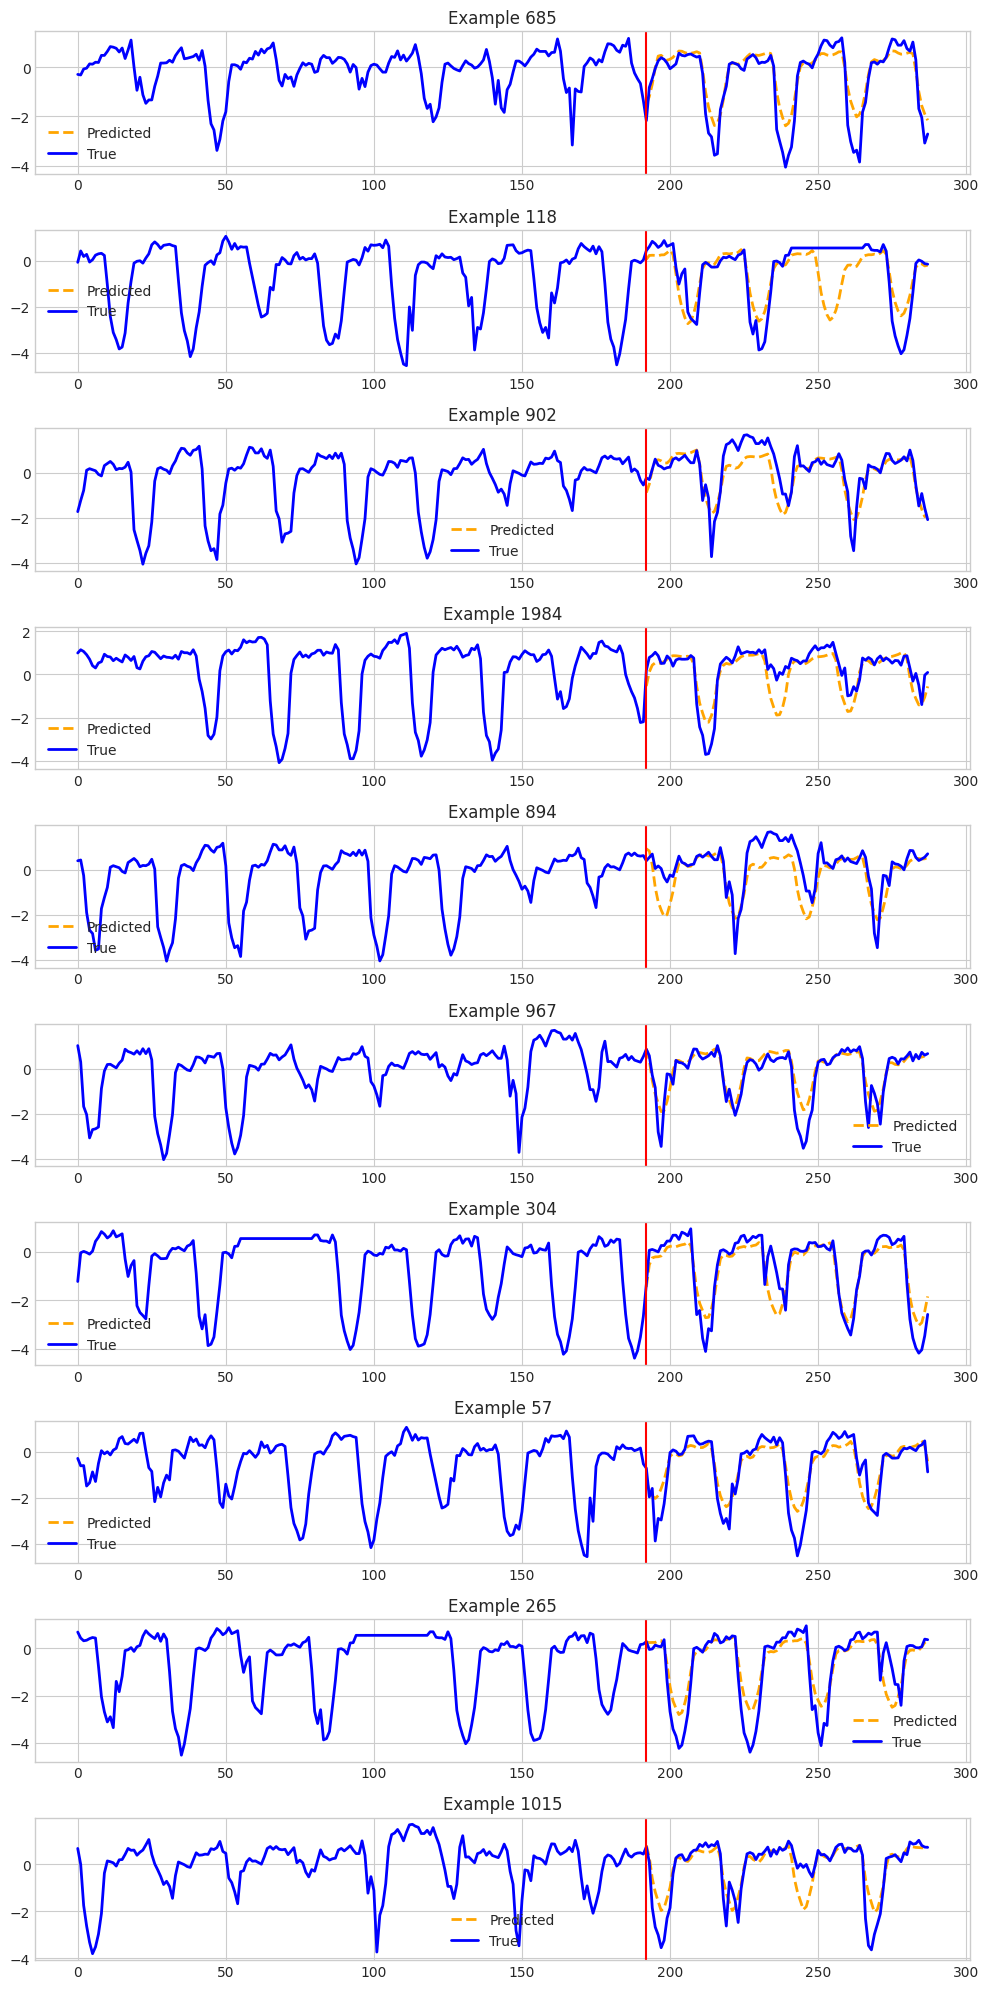

In [24]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=512, forecast_length=96, batch_size=64
)

config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.38679221272468567, 'eval_runtime': 1.4515, 'eval_samples_per_second': 1852.593, 'eval_steps_per_second': 15.157}
(2689, 192, 7)
(2689, 7, 8, 192)


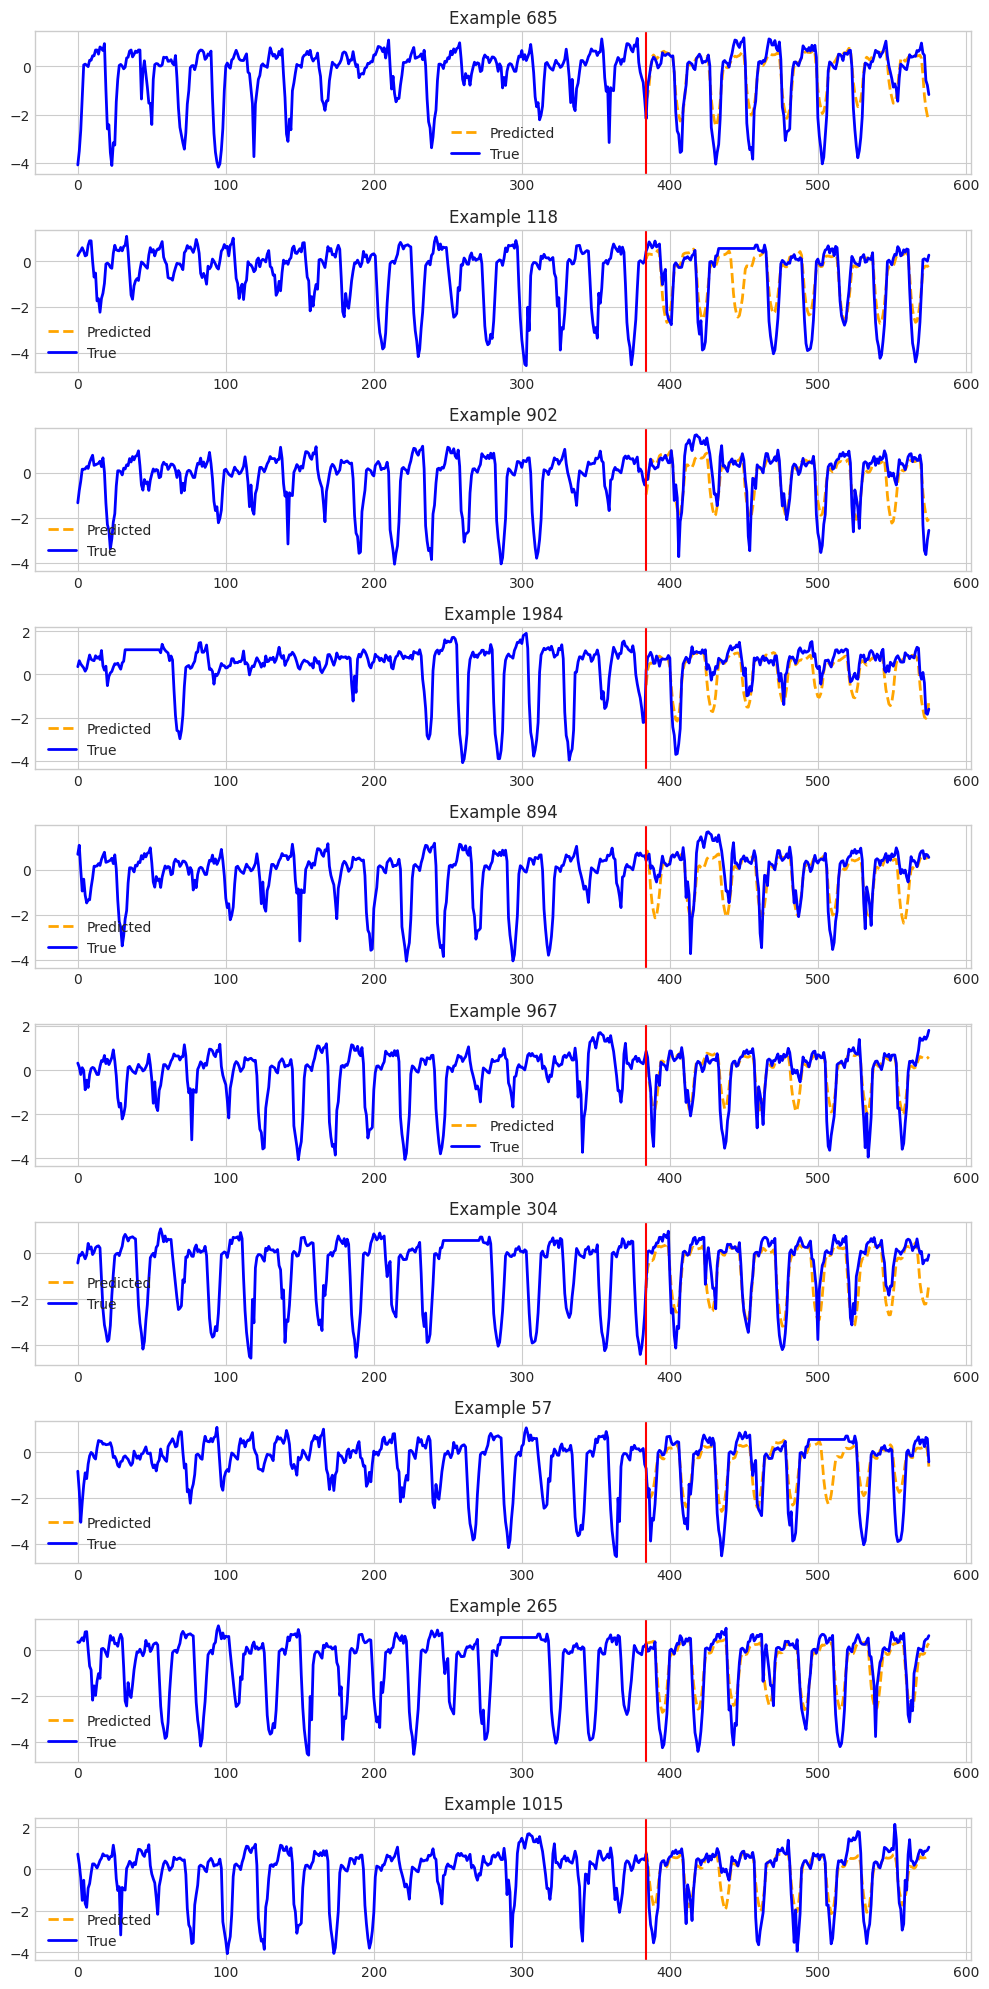

In [25]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=512, forecast_length=192, batch_size=64
)

config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.22M [00:00<?, ?B/s]

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.40231937170028687, 'eval_runtime': 1.0196, 'eval_samples_per_second': 2496.154, 'eval_steps_per_second': 19.616}
(2545, 336, 7)
(2545, 7, 8, 192)


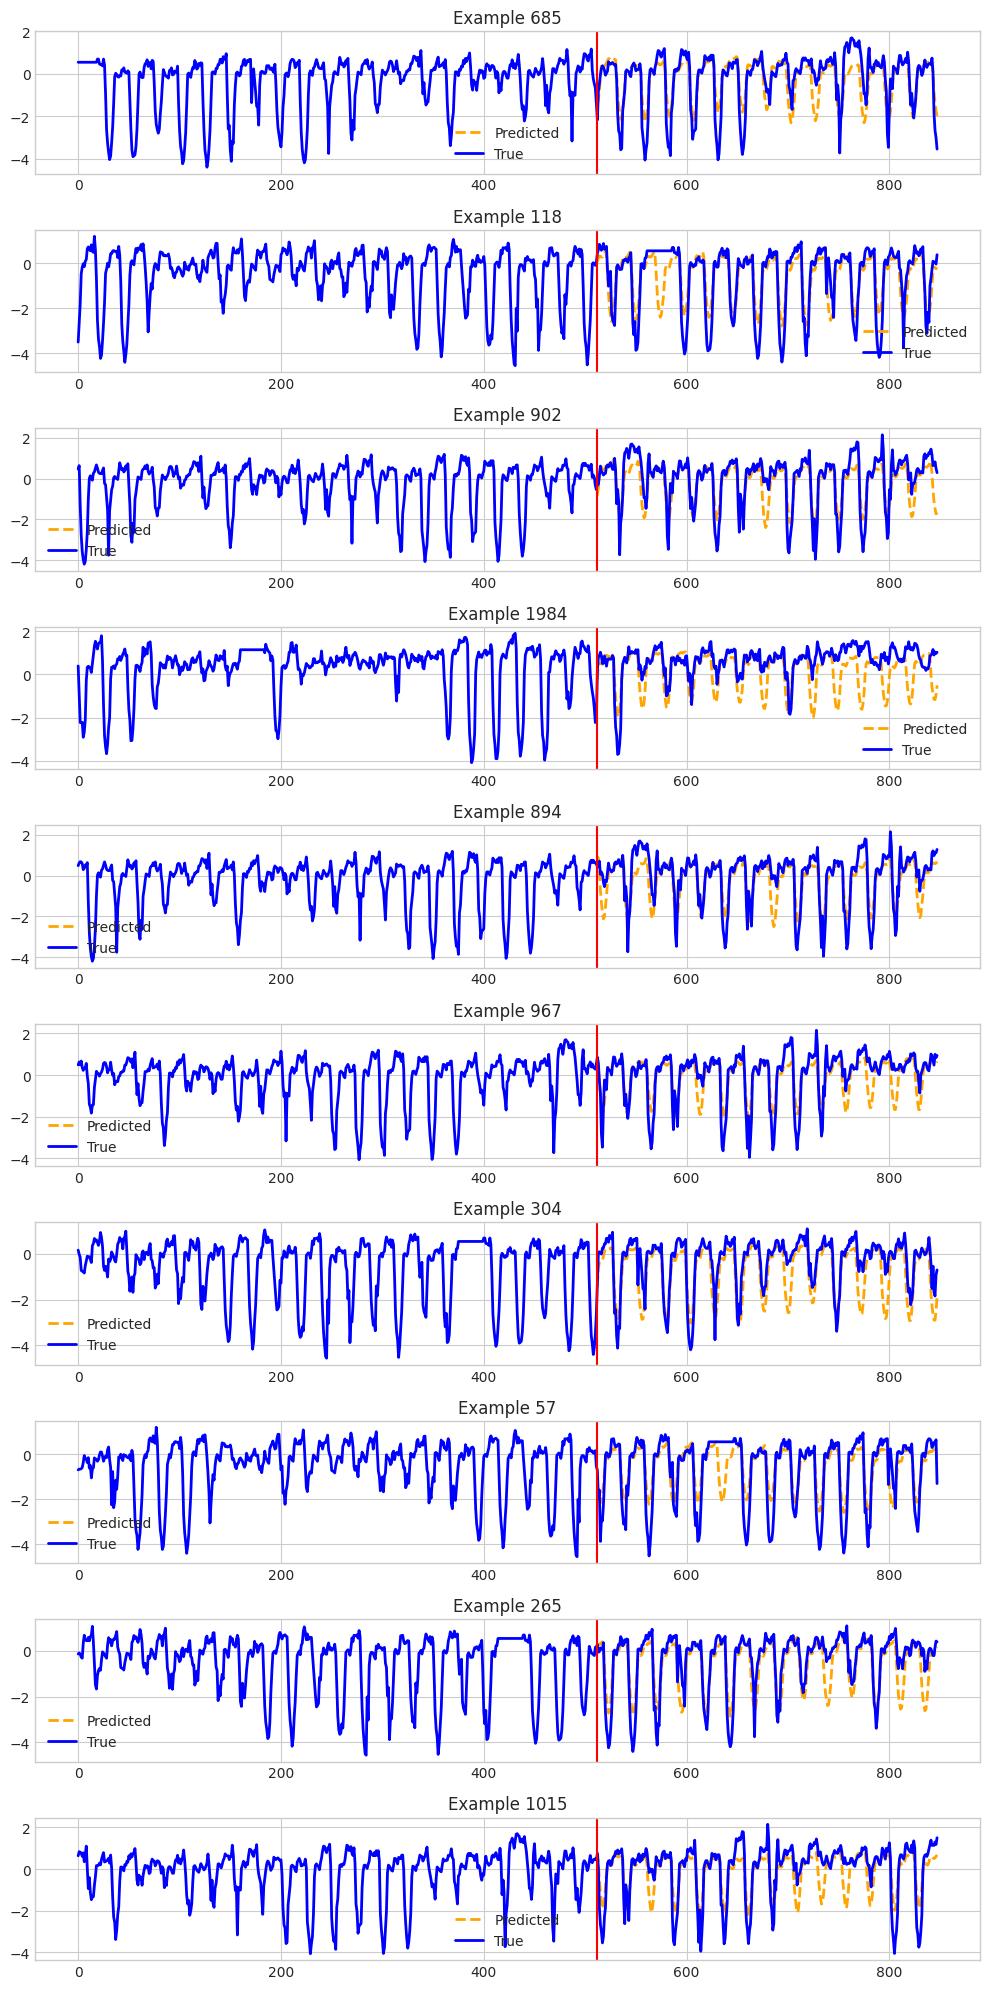

In [26]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=512, forecast_length=336, batch_size=64
)

config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.80M [00:00<?, ?B/s]

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.4754199683666229, 'eval_runtime': 0.8963, 'eval_samples_per_second': 2411.092, 'eval_steps_per_second': 18.967}
(2161, 720, 7)
(2161, 7, 8, 192)


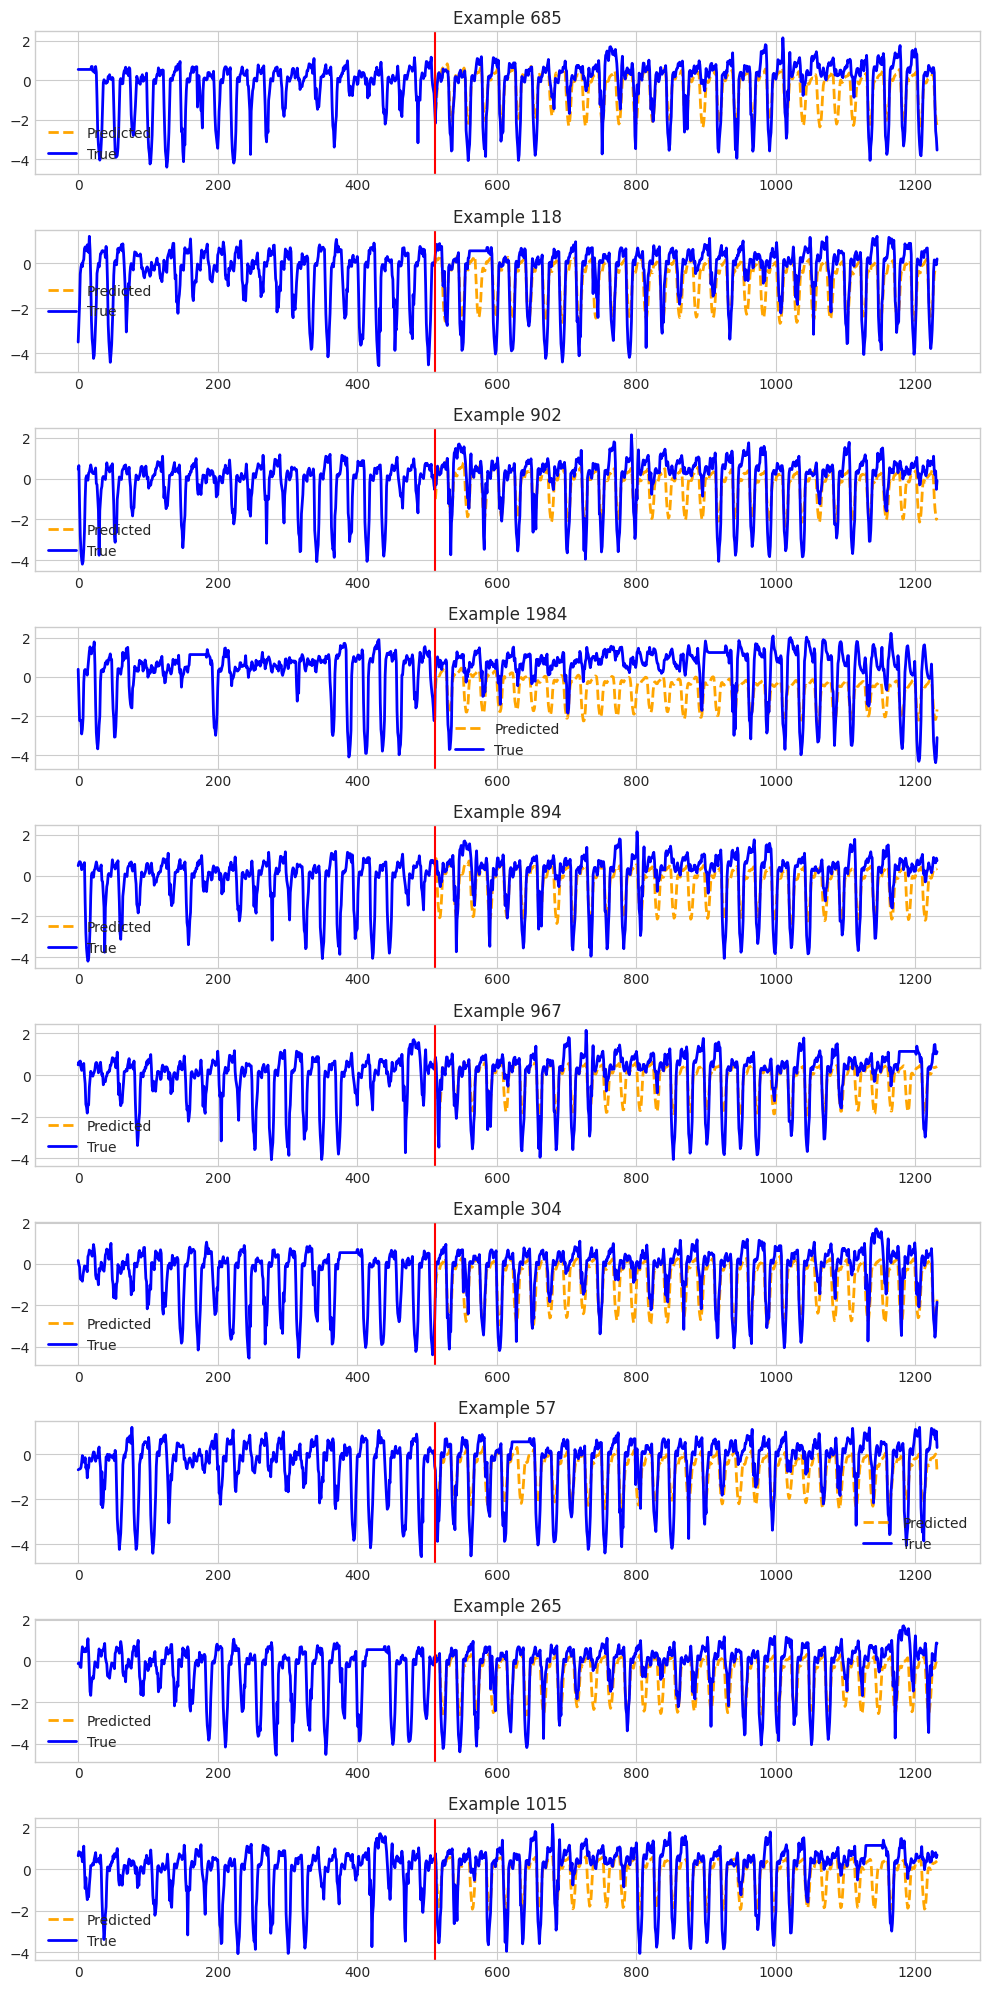

In [27]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=512, forecast_length=720, batch_size=64
)

# Replicate ETTm1 experiments

In [ ]:
TARGET_DATASET = "ettm1"
dataset_path = "/kaggle/input/ettdataset/ETTm1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

In [ ]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=512, forecast_length=96, batch_size=64
)

In [ ]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=512, forecast_length=192, batch_size=64
)

In [ ]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=512, forecast_length=336, batch_size=64
)

In [ ]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=512, forecast_length=720, batch_size=64
)